In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import numpy
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
import shsh.util, shsh.integrate
%pylab inline
from galpy.util import plot as galpy_plot
galpy_plot.start_print(axes_labelsize=17.,text_fontsize=12.,
                       xtick_labelsize=15.,ytick_labelsize=15.)

Populating the interactive namespace from numpy and matplotlib


# ``shsh``: an example shearing-sheet calculation

Set up the sheet for a logarithmic potential (that is, a flat rotation curve):

In [2]:
lp= LogarithmicHaloPotential(normalize=1.)
sheet= shsh.util.potential_to_sheet(lp,1.)

The sheet parameters are what we would expect:

In [3]:
sheet

{'R0': 1.0,
 'Omega0': 1.0,
 'A': 0.5,
 'Omega0pp': 2.000000032253979,
 'd4PhidR4': -6.000000096761937}

Use the orbit of the Sun, gotten using ``galpy``

In [4]:
orb= Orbit().toPlanar()[0] #orb= Orbit([1.,0.,1.01,0.])
vxvv= shsh.util.galpy_to_sheet(orb,sheet)

and integrate the orbit using ``galpy`` and ``shsh``:

In [5]:
ts= numpy.linspace(0.,30.,1001)
orb.integrate(ts,lp)
out= shsh.integrate.integrate(vxvv,ts,sheet['Omega0'],sheet['A'])

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')



We can compare the shearing-sheet solution to the full ``galpy`` solution in shearing sheet coordinates

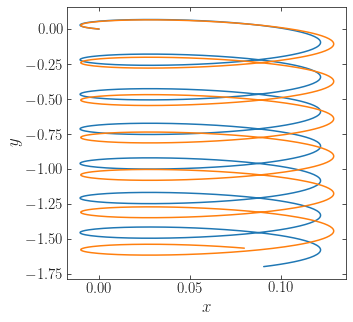

In [6]:
plot(out[0],out[1])
orb.turn_physical_off()
orb.integrate(ts,lp)
plot(*shsh.util.galpy_to_sheet(orb,sheet)[:2])
xlabel(r'$x$')
ylabel(r'$y$');

We can also convert to a ``galpy`` orbit and plot in, e.g., cylindrical coordinates:

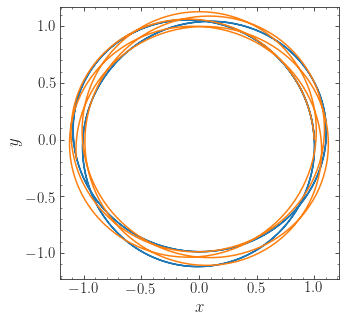

In [7]:
conv= shsh.util.sheet_to_galpy(*out,ts,sheet)
conv.plot()
orb.plot(overplot=True)

(note that these are Galactocentric $x$ and $y$, not shearing sheet). Or we can look at the energy

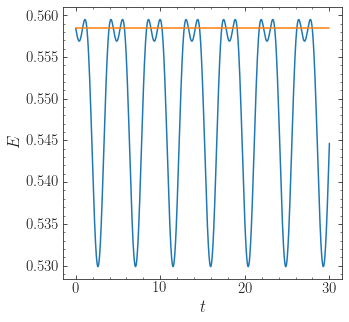

In [9]:
conv.plotE(pot=lp)
orb.plotE(overplot=True,pot=lp);

## Using the second order equations

To get a better solution, we can work out the equations to 2nd order in the small quantities and solve the resulting differential equation. Let's compare that solution to the first-order solution. We setup and integrate the same orbit as before:

In [10]:
orb= Orbit().toPlanar()[0] #orb= Orbit([1.,0.,1.01,0.])
vxvv= shsh.util.galpy_to_sheet(orb,sheet)

In [11]:
ts= numpy.linspace(0.,30.,1001)
orb.integrate(ts,lp)
out2= shsh.integrate.integrate2(vxvv,ts,sheet['Omega0'],sheet['A'],sheet['R0'],sheet['Omega0pp'])

We again compare the shearing-sheet solution to the full ``galpy`` solution in shearing sheet coordinates

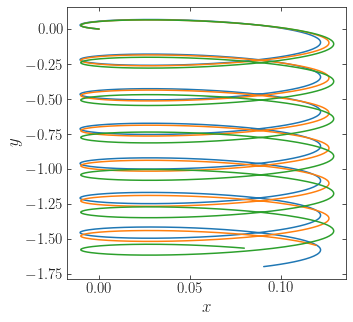

In [12]:
plot(out[0],out[1])
plot(out2[0],out2[1])
orb.turn_physical_off()
orb.integrate(ts,lp)
plot(*shsh.util.galpy_to_sheet(orb,sheet)[:2])
xlabel(r'$x$')
ylabel(r'$y$');

or we can again convert to a ``galpy`` orbit and plot in, e.g., cylindrical coordinates:

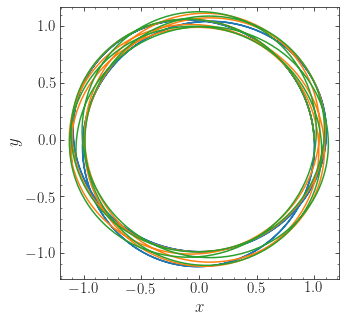

In [13]:
conv2= shsh.util.sheet_to_galpy(*out2,ts,sheet)
conv.plot()
conv2.plot(overplot=True)
orb.plot(overplot=True);

(note that these are Galactocentric $x$ and $y$, not shearing sheet). Or we can look at the energy

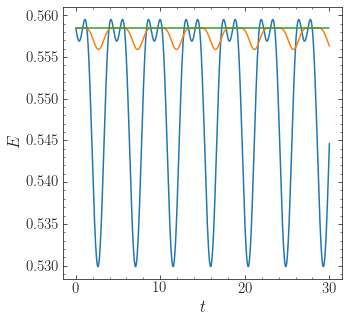

In [14]:
conv.plotE(pot=lp)
conv2.plotE(overplot=True,pot=lp)
orb.plotE(overplot=True,pot=lp);

Energy fluctuations along the orbit are noticeably smaller. Finally, we consider how well the azimuthal angle is tracked, by plotting the difference between the approximate azimuthal angle and the correct value:

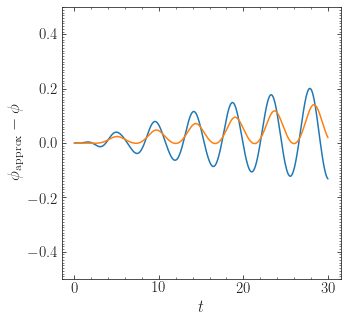

In [15]:
conv.plot(d1='t',d2=lambda t: (conv.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi)
conv2.plot(d1='t',d2=lambda t: (conv2.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi,overplot=True)
ylim(-0.5,0.5)
ylabel(r'$\phi_\mathrm{approx}-\phi$');

## Using the full, non-linear equations of motion

Finally, we also solve the shearing-sheet equations of motion found by keeping the full form of all terms in the Lagrangian except for the forces, which we instead work out to third order. We use the same orbit as before:

In [16]:
orb= Orbit().toPlanar()[0] #orb= Orbit([1.,0.,1.01,0.])
vxvv= shsh.util.galpy_to_sheet(orb,sheet)

In [17]:
ts= numpy.linspace(0.,30.,1001)
outf= shsh.integrate.integratef(vxvv,ts,sheet['Omega0'],sheet['A'],sheet['R0'],sheet['Omega0pp'],sheet['d4PhidR4'])

We can compare the shearing-sheet solution to the full ``galpy`` solution in shearing sheet coordinates

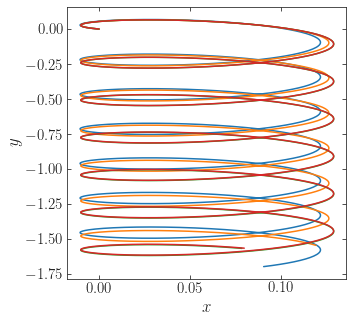

In [18]:
plot(out[0],out[1])
plot(out2[0],out2[1])
plot(outf[0],outf[1])
orb.turn_physical_off()
orb.integrate(ts,lp)
plot(*shsh.util.galpy_to_sheet(orb,sheet)[:2])
xlabel(r'$x$')
ylabel(r'$y$');

or we can again convert to a ``galpy`` orbit and plot in, e.g., cylindrical coordinates:

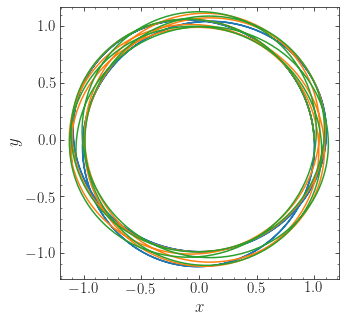

In [19]:
conv2= shsh.util.sheet_to_galpy(*out2,ts,sheet)
convf= shsh.util.sheet_to_galpy(*outf,ts,sheet)
conv.plot()
conv2.plot(overplot=True)
orb.plot(overplot=True);

(note that these are Galactocentric $x$ and $y$, not shearing sheet). Or we can look at the energy

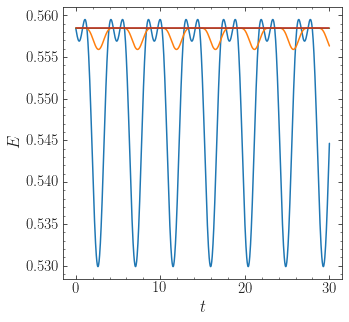

In [20]:
conv.plotE(pot=lp)
conv2.plotE(overplot=True,pot=lp)
convf.plotE(overplot=True,pot=lp)
orb.plotE(overplot=True,pot=lp);

The energy now does not noticeably fluctuate (however, it does, the fluctuations are just much smaller:

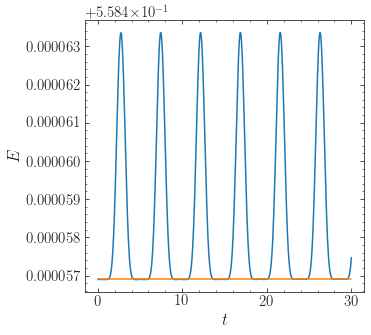

In [21]:
convf.plotE(pot=lp)
orb.plotE(overplot=True,pot=lp);

Finally, we again look at the difference between the approximate azimuthal angle and the correct value:

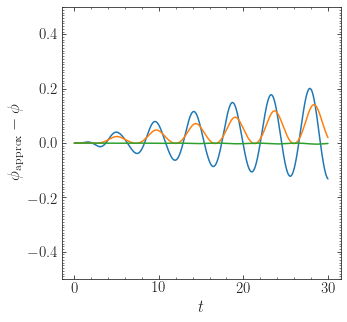

In [22]:
conv.plot(d1='t',d2=lambda t: (conv.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi)
conv2.plot(d1='t',d2=lambda t: (conv2.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi,overplot=True)
convf.plot(d1='t',d2=lambda t: (convf.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi,overplot=True)
ylim(-0.5,0.5)
ylabel(r'$\phi_\mathrm{approx}-\phi$');

## Backwards integration

The ODE solver that we are using cannot integrate backwards (that is, it assumes that the independent variable increases monotonically). To integrate backwards, we therefore have to (a) flip the sign of the velocities and (b) flip the sign of all frequencies ($\Omega_0$, $A$, and $\Omega_0''$). For example:

In [23]:
orb= Orbit().toPlanar()[0]
vxvv= list(shsh.util.galpy_to_sheet(orb,sheet))
vxvv[2]*= -1.
vxvv[3]*= -1.
ts= numpy.linspace(0.,30.,1001)
outb= shsh.integrate.integrate(vxvv,ts,-sheet['Omega0'],-sheet['A'])
outb[2]= outb[2]*-1.
outb[3]= outb[3]*-1.  

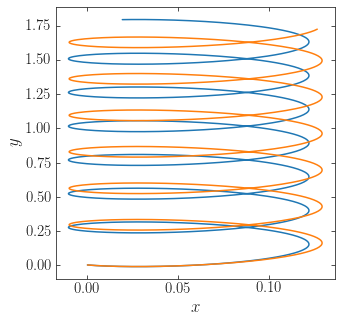

In [24]:
plot(outb[0],outb[1])
orb.turn_physical_off()
orb.integrate(-ts,lp)
plot(*shsh.util.galpy_to_sheet(orb,sheet)[:2])
xlabel(r'$x$')
ylabel(r'$y$');

## Adding perturbations

In [25]:
from galpy.potential import DehnenBarPotential, lindbladR
dp= DehnenBarPotential(alpha=0.01)
m= 2
oneovertanalpha= 0.
S0= dp(1.,0.,phi=dp._barphi)
S0p= -dp.Rforce(1.,0.,phi=dp._barphi)
S0pp= dp.R2deriv(1.,0.,phi=dp._barphi)
xc= lindbladR(lp,dp.OmegaP(),m='corot')-1.
phis= dp._barphi

In [26]:
orb= Orbit().toPlanar()[0]
#orb= Orbit([1.,0.1,0.75,0.])
vxvv= list(shsh.util.galpy_to_sheet(orb,sheet))
vxvv[2]*= -1.
vxvv[3]*= -1.
ts= numpy.linspace(0.,-dp.tform(),1001)
out= shsh.integrate.integrate(vxvv,ts,-sheet['Omega0'],-sheet['A'])
outp= shsh.integrate.integrate(vxvv,ts,-sheet['Omega0'],-sheet['A'],
                              1.,m,oneovertanalpha,S0,S0p,xc,phis,S0pp,-5.*S0pp)
outp2= shsh.integrate.integrate2(vxvv,ts,-sheet['Omega0'],-sheet['A'],sheet['R0'],-sheet['Omega0pp'],
                              sheet['R0'],m,oneovertanalpha,S0,S0p,-dp.OmegaP(),phis,S0pp,-5.*S0pp)
outpf= shsh.integrate.integratef(vxvv,ts,-sheet['Omega0'],-sheet['A'],sheet['R0'],-sheet['Omega0pp'],sheet['d4PhidR4'],
                              sheet['R0'],m,oneovertanalpha,S0,S0p,-dp.OmegaP(),phis,S0pp,-5.*S0pp)
outp[2]= outp[2]*-1.
outp[3]= outp[3]*-1.        
outp2[2]= outp2[2]*-1.
outp2[3]= outp2[3]*-1.        
outpf[2]= outpf[2]*-1.
outpf[3]= outpf[3]*-1.        

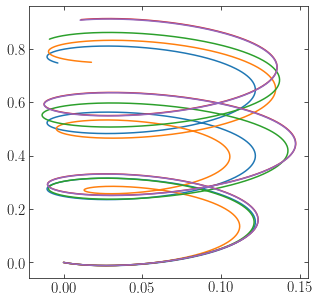

In [28]:
plot(out[0],out[1])
plot(outp[0],outp[1])
plot(outp2[0],outp2[1])
plot(outpf[0],outpf[1])
orb.integrate(-ts,lp+dp)
plot(*shsh.util.galpy_to_sheet(orb,sheet)[:2]);

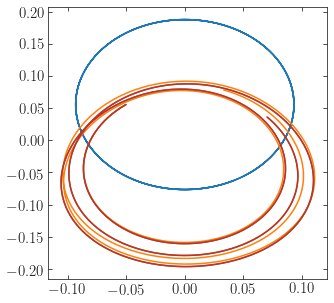

In [29]:
plot(out[2],out[3])
#plot(outp[2],outp[3])
plot(outp2[2],outp2[3])
plot(outpf[2],outpf[3])
plot(*shsh.util.galpy_to_sheet(orb,sheet)[2:]);

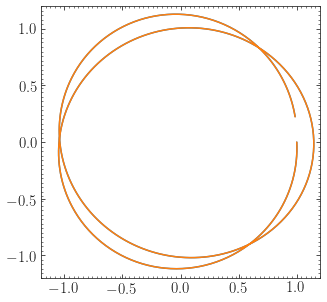

In [30]:
conv= shsh.util.sheet_to_galpy(*outp,-ts,sheet)
#conv.plot()
conv2= shsh.util.sheet_to_galpy(*outp2,-ts,sheet)
#conv2.plot(overplot=True)
convf= shsh.util.sheet_to_galpy(*outpf,-ts,sheet)
convf.plot(overplot=True)
orb.plot(use_physical=False,overplot=True)
xlim(-1.2,1.2)
ylim(-1.2,1.2);

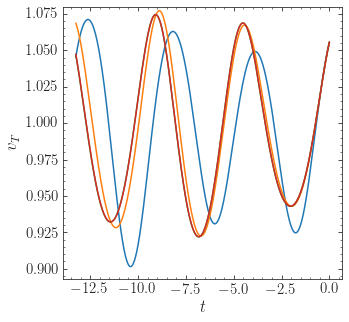

In [31]:
conv.plot(d1='t',d2='vT')
conv2.plot(d1='t',d2='vT',overplot=True)
convf.plot(d1='t',d2='vT',overplot=True)
orb.plot(d1='t',d2='vT',overplot=True,use_physical=False);

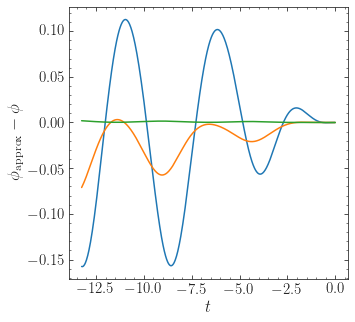

In [33]:
conv.plot(d1='t',d2=lambda t: (conv.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi)
conv2.plot(d1='t',d2=lambda t: (conv2.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi,overplot=True)
convf.plot(d1='t',d2=lambda t: (convf.phi(t)-orb.phi(t) + numpy.pi ) % (2.*numpy.pi) - numpy.pi,overplot=True);
#ylim(-1.8,0.4);
ylabel(r'$\phi_\mathrm{approx}-\phi$');

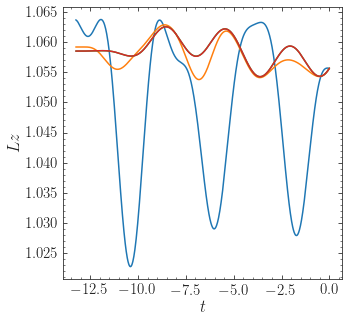

In [34]:
conv.plot(d2='Lz')
conv2.plot(d2='Lz',overplot=True)
convf.plot(d2='Lz',overplot=True)
orb.plot(d1='t',d2='Lz',use_physical=False,overplot=True);

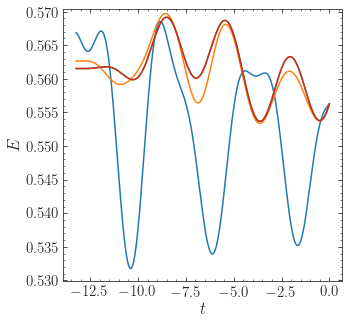

In [35]:
conv.plotE(pot=lp+dp)
conv2.plotE(pot=lp+dp,overplot=True)
convf.plotE(pot=lp+dp,overplot=True)
orb.plotE(d1='t',use_physical=False,overplot=True,pot=lp+dp);

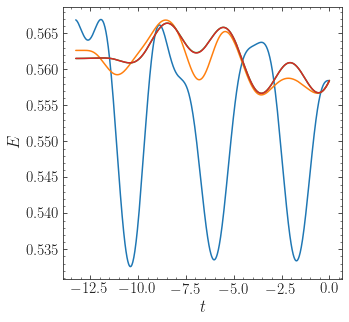

In [36]:
conv.plotE(pot=lp)
conv2.plotE(pot=lp,overplot=True)
convf.plotE(pot=lp,overplot=True)
orb.plotE(d1='t',use_physical=False,overplot=True,pot=lp);

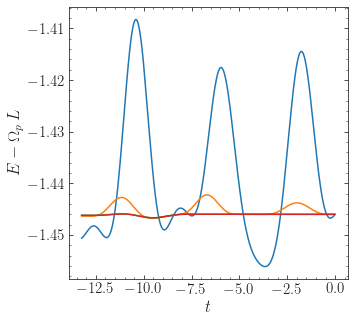

In [37]:
conv.plotJacobi(pot=lp+dp,OmegaP=dp.OmegaP())
conv2.plotJacobi(pot=lp+dp,OmegaP=dp.OmegaP(),overplot=True)
convf.plotJacobi(pot=lp+dp,OmegaP=dp.OmegaP(),overplot=True)
orb.plotJacobi(d1='t',use_physical=False,overplot=True,pot=lp+dp);

## The effect of the bar

In [27]:
grid= 31
ins= Orbit(numpy.array([[[1.,-0.7+1.4/(grid-1)*jj,1.-0.6+1.2/(grid-1)*ii,0.] 
                         for jj in range(grid)] for ii in range(grid)]))

In [28]:
from galpy.df import dehnendf
dfc= dehnendf(beta=0.,correct=True)

In [29]:
out= numpy.empty((len(ins),len(ins[0])))
ts= numpy.linspace(0.,-dp.tform(),1001)
for ii,os in enumerate(ins):
    for jj,o in enumerate(os):
        vxvv= list(shsh.util.galpy_to_sheet(o,sheet))
        vxvv[2]*= -1.
        vxvv[3]*= -1.
#        outp= shsh.integrate.integrate2(vxvv,ts,-sheet['Omega0'],-sheet['A'],sheet['R0'],-sheet['Omega0pp'],
#                                       1.,m,oneovertanalpha,S0,S0p,-dp.OmegaP(),phis,S0pp,-5.*S0pp)
        outp= shsh.integrate.integratef(vxvv,ts,-sheet['Omega0'],-sheet['A'],sheet['R0'],-sheet['Omega0pp'],
                                        sheet['d4PhidR4'],
                                       1.,m,oneovertanalpha,S0,S0p,-dp.OmegaP(),phis,S0pp,-5.*S0pp)
        outp[2]= outp[2]*-1.
        outp[3]= outp[3]*-1.        
        out[ii,jj]= dfc(shsh.util.sheet_to_galpy(*outp,ts,sheet)(ts[-1]))

/Users/bovy/tmp/galpy-spheredf/galpy/df/diskdf.py:1711: RuntimeWarning: overflow encountered in exp
  return self._gamma*numpy.exp(logsigmaR2-SRE2+self.targetSurfacemass(xE,log=True,use_physical=False)-logSigmaR+numpy.exp(logOLLE-SRE2)+correction[0])/2./numpy.pi



/Users/bovy/tmp/galpy-spheredf/galpy/util/plot.py:651: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



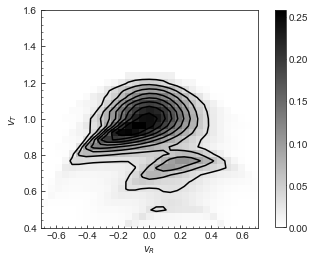

In [30]:
from galpy.util.plot import dens2d
dens2d(out,origin='lower',cmap='gist_yarg',contours=True,xrange=[-0.7,0.7],yrange=[0.4,1.6],
       xlabel=r'$v_R$',ylabel=r'$v_T$',colorbar=True);

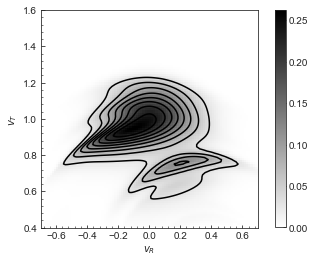

In [34]:
from galpy.util.plot import dens2d
dens2d(out,origin='lower',cmap='gist_yarg',contours=True,xrange=[-0.7,0.7],yrange=[0.4,1.6],
       xlabel=r'$v_R$',ylabel=r'$v_T$',colorbar=True);

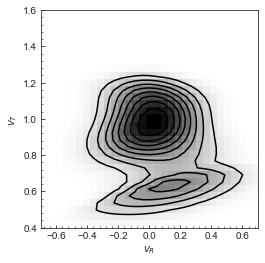

In [27]:
from galpy.util.plot import dens2d
dens2d(out,origin='lower',cmap='gist_yarg',contours=True,xrange=[-0.7,0.7],yrange=[0.4,1.6],
       xlabel=r'$v_R$',ylabel=r'$v_T$');

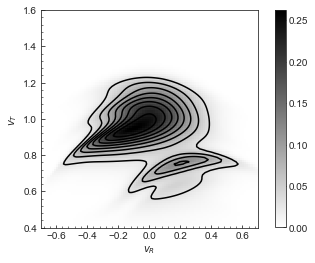

In [275]:
insg= Orbit(numpy.array([[[1.,-0.7+1.4/100*jj,1.-0.6+1.2/100*ii,0.] for jj in range(101)] for ii in range(101)]))
insg.integrate(-ts,[lp,dp])
outg= [[dfc(o(dp.tform())) for o in j] for j in insg]
outg= numpy.array(outg)
dens2d(outg,origin='lower',cmap='gist_yarg',contours=True,xrange=[-0.7,0.7],yrange=[0.4,1.6],
       xlabel=r'$v_R$',ylabel=r'$v_T$',colorbar=True);

## Using JAX

``ssh.integrate`` is written using JAX, so we can 'jit' the integration function or take derivatives. For example, jitting it

In [9]:
from jax import grad, jit
jintegrate= jit(shsh.integrate.integrate)
outj= jintegrate(vxvv,ts,sheet['Omega0'],sheet['A']) # force jit to happen!

We can compare:

In [10]:
%%timeit
shsh.integrate.integrate(vxvv,ts,sheet['Omega0'],sheet['A'])

722 µs ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit
jintegrate(vxvv,ts,sheet['Omega0'],sheet['A'])

695 µs ± 225 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


A little faster!

We can compute gradients as follows, for example, of the final $x$ position

In [12]:
gintegrate= grad(lambda x,*args: jintegrate(x,*args)[0][-1])

In [13]:
outg= gintegrate(vxvv,ts,sheet['Omega0'],sheet['A'])
print(outg)

(DeviceArray(1.98508647, dtype=float64), DeviceArray(0., dtype=float64), DeviceArray(-0.707029, dtype=float64), DeviceArray(0.98508647, dtype=float64))
